## Image Analysis Techniques to Detect Triple Lines
This looks at grain boundary atoms as defined by Ovitos using PTM and attempts to find intersection points which are potential triple lines. The main routine converted the atom positions into an integer array position initially form a square grid of side length $a=4.05$. The issue then becomes looking at the neighbouring squares to determine whether this is a grain boundary or potential triple line. At present the issue is more complicated as the skeletonize command is not consistently reduing the image to a continous set of curves all of which are one pixel wide.

In [107]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import LatticeDefinitions as ld
import GeometryFunctions as gf
import GeneralLattice as gl
import LAMMPSDump as LD
import scipy as sc
from skimage.morphology import skeletonize, thin, medial_axis
import os


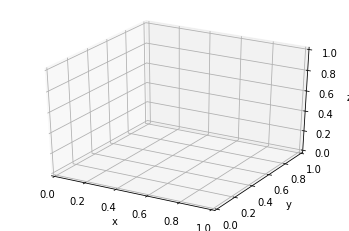

In [108]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
a1 = 4.05 ##lattice parameter
a2 = a1*np.sqrt(3) #periodic cell repeat multiple
l = 3
h= 4
z = a2*np.array([0,0,h])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
strDataFile = 'new.data'
#strDumpFile = 'dump.eam'
strDumpFile = 'data/60and30.eam'
strPMFile = strDumpFile + 'PM'
arr111BasisVectors = gf.RotatedBasisVectors(np.arccos(1/np.sqrt(3)), np.array([1,-1,0])/np.sqrt(2))
arrHorizontalVector = np.array([l*a2,0,0])
arrDiagonalVector =  np.array([a2*l/2, a2*l*np.sqrt(3)/2,0])

In [109]:
MySimulationCell = gl.SimulationCell(np.array([3*arrHorizontalVector,3*arrDiagonalVector, z])) 
objHex1 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, arr111BasisVectors, ld.FCCCell, np.array([a1,a1,a1]))
objHex2 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(20),z, arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]),-arrDiagonalVector+2*arrHorizontalVector)
objHex3 = gl.ExtrudedRegularPolygon(l*a2, h*a2, 6, gf.RotateVectors(gf.DegreesToRadians(40),z,arr111BasisVectors), ld.FCCCell, np.array([a1,a1,a1]), arrHorizontalVector + arrDiagonalVector)
MySimulationCell.AddGrain(objHex1)
MySimulationCell.AddGrain(objHex2)
MySimulationCell.AddGrain(objHex3)
MySimulationCell.WrapAllPointsIntoSimulationCell()
MySimulationCell.RemovePlaneOfAtoms(np.array([[0,0,1,a2*h]]),0.1)
#MySimulationCell.WriteLAMMPSDataFile(strDataFile)

In [110]:
objData = LD.LAMMPSData(strPMFile)
objTimeStep = objData.GetTimeStepByIndex(0)
objTimeStep.StandardiseOrientationData()
objPostProcess = LD.OVITOSPostProcess(np.array([objHex1.GetQuaternionOrientation(), 
                                                objHex2.GetQuaternionOrientation(), 
                                                objHex3.GetQuaternionOrientation()]), objTimeStep, 1)

In [111]:
print(objTimeStep.GetColumnNames())


['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'c_pe1', 'StructureType', 'OrientationW', 'OrientationX', 'OrientationY', 'OrientationZ']


In [112]:
MyData = np.zeros([objTimeStep.GetNumberOfAtoms(),5])
MyData[:,0:3] = objTimeStep.GetAtomData()[:,1:4]
MyData[:,3] = objTimeStep.GetAtomData()[:,7]
MyData[:,4] = objTimeStep.GetAtomData()[:,8]
print(MyData[:,0:2])

[[  1.6697201   0.510324 ]
 [  1.1355799   0.906263 ]
 [  2.6756699   2.6503799]
 ...
 [338.3280029 193.2389984]
 [338.2919922 197.6390076]
 [338.381012  197.4859925]]


In [113]:
xMax = np.max(MyData[:,0])
yMax = np.max(MyData[:,1])
zMax = np.max(MyData[:,2])
print(xMax,yMax,zMax)

344.348999 199.9149934 8.0999498


In [114]:
fltA = a1
arrRoundedPoints = np.zeros([int(2*np.ceil(xMax)/fltA)+2,int(2*np.ceil(yMax)/fltA)+2])
intVector1 = objTimeStep.GetCellVectors()[0]
intVector2 = objTimeStep.GetCellVectors()[1]
intVector3 = objTimeStep.GetCellVectors()[0]+objTimeStep.GetCellVectors()[1]

In [115]:
for j in MyData:
    if j[4].astype('int') == 0:
        #j =np.matmul(objTimeStep.GetUnitBasisConversions()[:2,:2],np.array(j[0:2]))
        arrRoundedPoints[int(np.round(j[0])/fltA), int(np.round(j[1])/fltA)] += 1
        arrRoundedPoints[int(np.round((j[0]+intVector1[0])/fltA)), int(np.round((j[1]+intVector1[1])/fltA))] += 1
        arrRoundedPoints[int(np.round((j[0]+intVector2[0])/fltA)), int(np.round((j[1]+intVector2[1])/fltA))] += 1
        arrRoundedPoints[int(np.round((j[0]+intVector3[0])/fltA)), int(np.round((j[1]+intVector3[1])/fltA))] += 1
arrRoundedPoints[arrRoundedPoints > 2] =1
arrRoundedPoints = (arrRoundedPoints.astype('bool')).astype('int')
np.shape(arrRoundedPoints)

(172, 100)

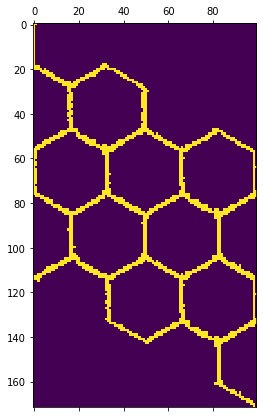

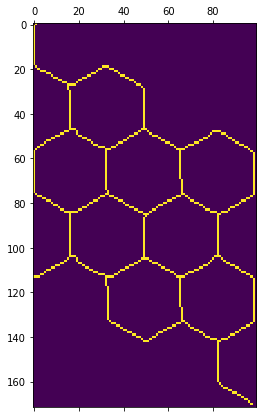

In [116]:
skPoints = skeletonize(arrRoundedPoints)
skPoints = thin(skPoints).astype('int')
plt.matshow(arrRoundedPoints)
plt.matshow(skPoints)
plt.show()

In [117]:
arrArgList = np.argwhere(skPoints ==1)

In [118]:
n=3
arrTotal =np.zeros(4*n)
intLow = int((n-1)/2)
intHigh = int((n+1)/2)
skPoints2 = np.copy(skPoints)
for arrPoint in arrArgList: #loop through the array positions which have GB atoms
    arrCurrent = skPoints[arrPoint[0]-intLow:arrPoint[0]+intHigh,arrPoint[1]-intLow:arrPoint[1]+intHigh] #sweep out a 5 x 5 square of array positions with
    intSwaps = 0
    if np.shape(arrCurrent) == (n,n): #centre j. This check avoids boundary points
        intValue = arrCurrent[0,0]
        arrTotal[:n ] = arrCurrent[0,:]
        arrTotal[n:2*n] =  arrCurrent[:,-1]
        arrTotal[2*n:3*n] = arrCurrent[-1,::-1]
        arrTotal[3*n:4*n] = arrCurrent[-1::-1,0]
        for k in arrTotal:
            if (k!= intValue):
                intSwaps += 1
                intValue = k
        if intSwaps == 6:
            if not (arrCurrent[0].all() == 1 or arrCurrent[-1].all() == 1 or arrCurrent[:,0].all() == 1 or arrCurrent[:,-1].all() ==1):
                skPoints2[arrPoint[0],arrPoint[1]]=2
        if intSwaps < 4:
                skPoints2[arrPoint[0],arrPoint[1]]=3
      #  elif intSwaps ==4:
      #      if arrCurrent[0].all() == 1 or arrCurrent[-1].all() == 1 or arrCurrent[:,0].all() == 1 or arrCurrent[:,-1].all() ==1:
      #          skPoints2[arrPoint[0],arrPoint[1]]=2
            #if arrCurrent[intHigh, :].all() ==1 or arrCurrent[:,intHigh].all() ==1:
            #       skPoints2[arrPoint[0],arryPoint[1]]=2
            
            

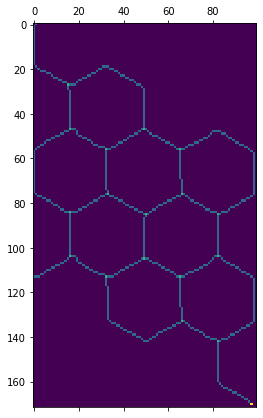

In [119]:
plt.matshow(skPoints2)
plt.show()

In [120]:
arrTripleLine = np.argwhere(skPoints2 ==2)
print(arrTripleLine, len(arrTripleLine), intVector1/fltA, intVector2/fltA)



[[ 27  15]
 [ 47  16]
 [ 47  49]
 [ 56  32]
 [ 56  65]
 [ 76  33]
 [ 76  66]
 [ 84  16]
 [ 85  50]
 [ 85  82]
 [104  16]
 [104  82]
 [105  49]
 [113  32]
 [113  65]
 [133  66]
 [142  82]] 17 [56.99999773  0.          0.        ] [28.50000077 49.36344854  0.        ]


In [121]:
TriplePoints = np.zeros([len(arrTripleLine),3])
TriplePoints[:,0] = fltA*arrTripleLine[:,1]
TriplePoints[:,1] = fltA*arrTripleLine[:,0]
print(TriplePoints)
arrPoints = objTimeStep.MoveToSimulationCell(TriplePoints)
print(arrPoints)                      

[[ 60.75 109.35   0.  ]
 [ 64.8  190.35   0.  ]
 [198.45 190.35   0.  ]
 [129.6  226.8    0.  ]
 [263.25 226.8    0.  ]
 [133.65 307.8    0.  ]
 [267.3  307.8    0.  ]
 [ 64.8  340.2    0.  ]
 [202.5  344.25   0.  ]
 [332.1  344.25   0.  ]
 [ 64.8  421.2    0.  ]
 [332.1  421.2    0.  ]
 [198.45 425.25   0.  ]
 [129.6  457.65   0.  ]
 [263.25 457.65   0.  ]
 [267.3  538.65   0.  ]
 [332.1  575.1    0.  ]]
[[291.5999908 109.35        0.       ]
 [295.6499908 190.35        0.       ]
 [198.45      190.35        0.       ]
 [245.0249877  26.8780334   0.       ]
 [147.8249969  26.8780334   0.       ]
 [249.0749877 107.8780334   0.       ]
 [151.8749969 107.8780334   0.       ]
 [180.2249877 140.2780334   0.       ]
 [ 87.0749969 144.3280334   0.       ]
 [216.6749969 144.3280334   0.       ]
 [ 64.7999846  21.3560668   0.       ]
 [101.2499938  21.3560668   0.       ]
 [198.4499846  25.4060668   0.       ]
 [129.5999846  57.8060668   0.       ]
 [263.2499846  57.8060668   0.       ]
 [267.

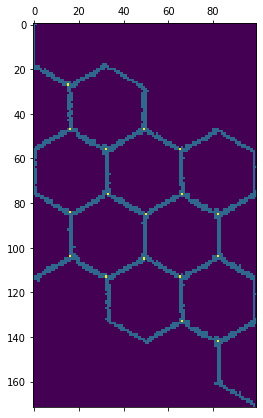

In [122]:
for j in arrTripleLine:
    arrRoundedPoints[j[0],j[1]] = 3
plt.matshow(arrRoundedPoints)
plt.show()